# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Tuple
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm

# Forward Pass

## Linear Layer Forward

In [2]:
def linear_layer_forward(x: np.ndarray,w: np.ndarray,b: np.ndarray):

    '''
    Computes forward pass for simple linear layer 
    

    Input: 
    x: Numpy array containing input data, N x H x W we flatten last two dimensions so its N x D
    w: Numpy array of weights, D x M
    b: Numpy array of bias, M x
    
    Output:


    output: Numpy array after matrix multiplication, N x M
    cache: Cache of input params to be used in backward pass
    
    '''
    
    
    #Initialize weights and bias for this layer

    output = (x @ w) + b
    
    cache = (x,w,b)
    return output, cache

## Sigmoid Function Forward

In [3]:
def sigmoid_activation_forward(x: np.ndarray) -> (np.ndarray):

    '''
    
    Apply sigmoid function on given input
    
    Input:

    x: Numpy array, NxD

    Output:

    output: Numpy array after sigmoid activation , NxD

    '''

    output  = 1 / (1 + np.exp(-x))

    cache = x

    return output,cache

## Softmax Layer Forward

In [4]:
def softmax_activation_forward(x: np.ndarray) -> (np.ndarray):
    
    '''
    Apply softmax function on given input
    
    Input:

    x: Numpy array, NxD

    Output:

    output: Numpy array after softmax activation , NxD

    '''

    normalize_input = x - np.amax(x,axis=1,keepdims=True)
    output = (np.exp(normalize_input).T / np.sum(np.exp(normalize_input), axis=1)).T

    cache = x

    return output,cache

# Loss

In [5]:
def MSE_loss(y_pred: np.ndarray, y: np.ndarray) -> float:
    
    '''
    Computes Mean squared error loss
    
    Input:

    y: Numpy array containg ground truth labels, NxD
    y_pred: Numpy array from network, NxD

    Output:

    loss: scaler, mean squared error loss
    gradient: gradient w.r.t y_pred used for backward pass

    '''


    N = y.shape[0]
    k = y.shape[1]
    
    loss =  (np.sum(np.sum((y_pred-y)**2,axis=1)/k))/N
    
    return loss

# Backward Pass

## Linear Backward Layer

In [6]:
def linear_layer_backward(upstream,cache):

    x,w,b = cache  
    dx = (upstream @ w.T).reshape(x.shape)
    dw = (upstream.T @ x).reshape(w.shape)
    db = np.sum(upstream)


    return dx,dw,db

## Sigmoid Backward Layer

In [7]:
def sigmoid_layer_backward(upstream,cache):

    x = cache

    sigmoid = 1 /( 1 + np.exp(-x))
    sigmoid_derivative = (sigmoid * (1 - sigmoid))

    dx = (upstream * sigmoid_derivative)

    return dx

## Softmax Activation Layer

In [8]:
def softmax_layer_backward(cache,y):

    x = cache
    s,_ = softmax_activation_forward(x)
    ds = np.zeros((x.shape[0],x.shape[1]))
    
    for i in range(x.shape[0]):
        
        s_vector = s[i].reshape((s[i].shape[0],1))
        s_matrix = np.tile(s_vector,s[i].shape[0])
        softmax_derivative = np.sum((s[i]-y[i]) * (np.diag(s[i]) - (s_matrix * np.transpose(s_matrix))),axis=1)
        ds[i] = softmax_derivative

    return ds

# DataLoader

In [9]:
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True)


In [10]:
images_train = len(train_dataset)
images_test  = len(test_dataset)

print("Images Train %d"%(images_train))
print("Images Test %d"%(images_test))

Images Train 60000
Images Test 10000


In [11]:
BATCH_SIZE = 20
SHUFFLE = True

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=SHUFFLE)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=SHUFFLE)

# Model

## One Hot Encoding

In [13]:
def array_to_one_hot(arr, C):
    one_hot = np.zeros((arr.shape[0], C))

    for i in range(arr.shape[0]):

        idx = int(arr[i])
        one_hot[i, idx] = 1

    return one_hot

## Model Class

In [14]:
class TwoLayerModel(object):

    def __init__(self,input_dim: int, hidden_dim: int, output_dim: int) -> None:

        self.params = {}


        #Initialize weights and bias

        self.params['w1'] = np.random.uniform(-0.5, 0.5, (input_dim, hidden_dim))
        self.params['b1'] = np.zeros((hidden_dim,))
        self.params['w2'] = np.random.uniform(-0.5,0.5, (hidden_dim,output_dim))
        self.params['b2'] = np.zeros((output_dim,))
        
        pass
    

    # def forward

    def loss(self,X,y=None):


        #Forward Pass 

        x,cache_linear_1 = linear_layer_forward(X,self.params['w1'],self.params['b1'])
        x,cache_sigmoid  = sigmoid_activation_forward(x)
        x,cache_linear_2 = linear_layer_forward(x,self.params['w2'],self.params['b2'])
        y_pred,cache_softmax = softmax_activation_forward(x)


        if y is None:
            return y_pred

        loss = 0
        grads = {}

        # Calculate loss

        loss = MSE_loss(y_pred,y)


        #Backward pass
    
        dsoftmax_activation = softmax_layer_backward(cache_softmax,y)
        dx2,dw2,db2 = linear_layer_backward(dsoftmax_activation,cache_linear_2)
        dsigmoid_activation = sigmoid_layer_backward(dx2,cache_sigmoid)
        dx1,dw1,db1 = linear_layer_backward(dsigmoid_activation,cache_linear_1)


        grads['w1'] = dw1
        grads['w2'] = dw2
        # grads['b1'] = db1
        # grads['b2'] = db2

        return loss,grads


    def check_accuracy(self,data,labels):

        y_pred = []
        probs = self.loss(data)

        y_pred.append(np.argmax(probs,axis=1))

        y_pred = np.hstack(y_pred)
        
        acc = np.mean(y_pred == labels)

        return acc
    
    def train(self,dataloader,iterations,learning_rate):

        loss_train = []
        acc_train = []
        progress_bar = tqdm(range(iterations), total=iterations)
        for t in progress_bar:
            loss = 0.0
            grads_train = {}
            acc = 0.0
            for i,(imgs,labels) in enumerate(dataloader):

                X_batch = imgs.squeeze(1).reshape((imgs.shape[0],np.prod(imgs.shape[1:],axis=0))).cpu().numpy()
                y_batch = array_to_one_hot(labels.cpu().numpy(),10)

                loss_batch,grad_batch = self.loss(X_batch,y_batch)

                loss += loss_batch

                for k,v in grad_batch.items():
                    
                    partial_derivative = grad_batch[k]

                    update = self.params[k] - (learning_rate * partial_derivative)

                    self.params[k] = update

                acc_batch = self.check_accuracy(X_batch,labels.cpu().numpy())
                acc += acc_batch
            # print(acc/len(dataloader))
            loss_train.append(loss)
            acc_train.append(acc)
            progress_bar.set_description(f"Iter {t+1}: loss {loss:.5f}. ")

        return loss_train,acc_train

# Training

In [15]:
model = TwoLayerModel(784,64,10)
loss,acc_train = model.train(train_loader,2000,1e-5)  

Iter 2000: loss 327.68709. : 100%|██████████| 2000/2000 [4:30:39<00:00,  8.12s/it]


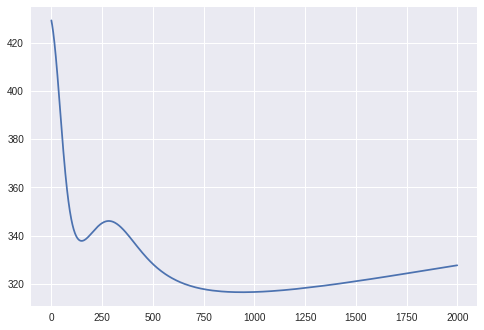

In [16]:
plt.style.use('seaborn')

plt.plot(loss)

# Testing/Validation

# Plots